In [1]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

In [2]:
name = "arjunth2001/priv_ftc"
model = AutoModelForSequenceClassification.from_pretrained(name)
tokenizer = AutoTokenizer.from_pretrained(name)

In [3]:
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer,device=0)
#pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

In [4]:
labels=['First Party Collection/Use',
          'Third Party Sharing/Collection',
          'Other',
          'International and Specific Audiences',
          'Data Security',
          'User Choice/Control',
          'User Access, Edit and Deletion',
          'Data Retention',
          'Policy Change',
          'Do Not Track']

In [5]:
counter ={t:{l:0 for l in labels} for t in ["GDPR","NGDPR"]}
def get_preds(t,x):
    global counter
    try:
        x =eval(x)
        preds = list(set(i["label"] for i in pipe(x)))
        for p in preds:
            counter[t][p]+=1
        return preds
    except:
        return []

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv("GDPR_Analysis.csv")

In [8]:
from tqdm.auto import tqdm
tqdm.pandas()
df["gpreds"]=df["GDPR_Text"].progress_apply(lambda x: get_preds("GDPR",x))
df["ngpreds"]=df["NGDPR_Text"].progress_apply(lambda x: get_preds("NGDPR",x))

  0%|          | 0/582 [00:00<?, ?it/s]

/home2/arjunth2001/miniconda3/envs/legal/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/home2/arjunth2001/miniconda3/envs/legal/lib/python3.7/site-packages/transformers/pipelines/base.py:901: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

  0%|          | 0/582 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [9]:
import json
with open("GDPR.json","w") as f:
    json.dump(counter,f,indent=4)

In [10]:
df.to_csv("GDPR_policies.csv",index=False)

In [11]:
len(df)

582

In [14]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')
emb1 = model.encode("This is a red cat with a hat.")
emb2 = model.encode("Have you seen my red cat?")
cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim.item())

Cosine-Similarity: 0.6153061389923096


In [17]:
sims = []
for i in tqdm(range(len(df))):
    emb1 = model.encode(" ".join(eval(df["GDPR_Text"][i])))
    emb2 = model.encode(" ".join(eval(df["NGDPR_Text"][i])))
    cos_sim = util.cos_sim(emb1, emb2)
    sims.append(cos_sim.item())

  0%|          | 0/582 [00:00<?, ?it/s]

In [18]:
df["sims"]=sims

<AxesSubplot:>

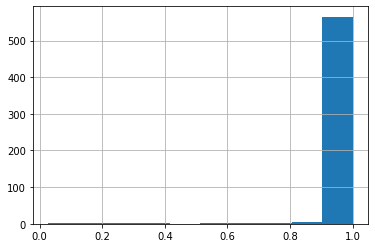

In [20]:
df["sims"].hist()

In [21]:
with open("sims.json","w") as f:
    json.dump(sims,f,indent=4)